In [1]:
#Loading the required packages
import numpy as np   # Linear algebra
import pandas as pd   #Data processing, CSV file I/O 
import seaborn as sns   #Statistical data visualization
from scipy.stats import skew   # For some statistics
from sklearn.model_selection import KFold, cross_val_score   #Evaluate a score by cross-validation
from sklearn.metrics import mean_squared_error   #Mean squared error regression loss
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV   # Loading models
from sklearn.pipeline import make_pipeline   #Construct a Pipeline from the given estimators
from sklearn.preprocessing import RobustScaler   #Scale features using statistics that are robust to outliers
import matplotlib.pyplot as plt   #pyplot is matplotlib's plotting framework. That specific import line merely imports the module "matplotlib.pyplot" and binds that to the name "plt"
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import and put the train and test datasets in pandas dat aframe
train = pd.read_csv('https://raw.githubusercontent.com/YeqingChen1995/CS634_Midterm_Project_1/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/YeqingChen1995/CS634_Midterm_Project_1/master/test.csv')

In [3]:
#Finding the features need to be deleted from the training set
train.isnull().sum().sort_values(ascending=False)[:20]/len(train)*100
#Delete the feature of excessive missing values

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Utilities        0.000000
dtype: float64

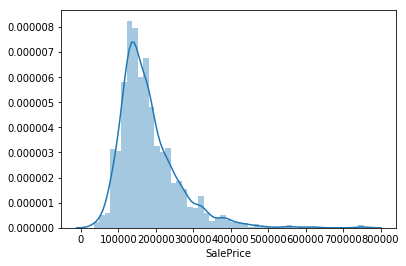

In [4]:
#Let's look at the distribution of prices.
SalePrice = train['SalePrice']
Id = test['Id']
sns.distplot(SalePrice)
#It is found that the selling price is not a normal distribution and the deviation is obvious.

In [5]:
#Apply Log1p processing of selling price to make it normal distribution
SalePrice = np.log1p(SalePrice)

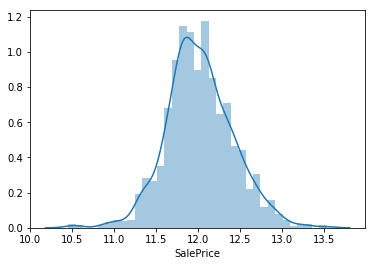

In [6]:
#Let's look at the distribution of prices again.
sns.distplot(SalePrice)
#It's much better now.

In [7]:
#display the first five rows of the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
#display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
#Drop the 'Id' colum and 'SalePrice' colume since they are unnecessary for the prediction process
#Combine training set and test set to facilitate data preprocessing together
train.drop(['SalePrice'], axis=1, inplace=True)
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
full=pd.concat([train,test], ignore_index=True)

In [10]:
#Check again the data size after dropping 'Id' and 'SalePrice' variables
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [11]:
#Check again the data size after dropping the 'Id' variable
test.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
#Delete the feature of excessive missing values found above
full.drop(['PoolQC'], axis=1, inplace=True)
full.drop(['Alley'], axis=1, inplace=True)
full.drop(['FireplaceQu'], axis=1, inplace=True)

In [13]:
#Change the data type of feature MSSubClass from numeric to a string
full['MSSubClass'] = full['MSSubClass'].apply(str)

In [14]:
#Fill in all missing values according to the actual situation
full['Functional']=full['Functional'].fillna('Typ')
full['Electrical']=full['Electrical'].fillna("SBrkr")
full['KitchenQual']=full['KitchenQual'].fillna("TA")
full['MasVnrArea']=full['MasVnrArea'].fillna(np.median(full['MasVnrArea'][full['MasVnrArea'].notnull() == True])) 
for col in ('SaleType','Exterior1st','Exterior2nd'):
    full[col]=full[col].fillna(full[col].mode()[0])
for col in ('GarageYrBlt','GarageArea','GarageCars','BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'):
    full[col]=full[col].fillna(0)
for col in ['MiscFeature','Fence','GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    full[col]=full[col].fillna('None')
for col in ('Utilities','MasVnrType'):
    full[col]=full[col].fillna('Unkonwn')
full['MSZoning']=full.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
full['LotFrontage']=full.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [15]:
#Combine some strongly related features to reduce the dimensionality of data(Quoted from https://www.kaggle.com/jesucristo/house-prices-solution-0-107-lb)
full['YrMoSold']=full['YrSold']+(1/12*full['MoSold'])
full['Total_BsmtSF']=full['BsmtFinSF1']+full['BsmtFinSF2']
full['Total_Bath']=full['FullBath']+(0.5*full['HalfBath'])
full['Total_BsmtBath']=full['BsmtFullBath']+(0.5*full['BsmtHalfBath'])
full['Total_porch_sf']=full['OpenPorchSF']+full['3SsnPorch']+full['EnclosedPorch']+full['ScreenPorch']
for col in ('YrSold','MoSold','BsmtFinSF1','BsmtFinSF2','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath','OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch'):
    full.drop([col], axis=1, inplace=True)

In [16]:
#Adjust high skewness numeric features(Quoted from https://www.kaggle.com/jesucristo/house-prices-solution-0-107-lb)
numeric_dtypes = ['int64', 'float64']
numerics2 = []
for i in full.columns:
    if full[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = full[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

In [17]:
skew_index

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'KitchenAbvGr',
       'MasVnrArea', 'Total_porch_sf', 'WoodDeckSF', 'LotFrontage', '1stFlrSF',
       'GrLivArea', 'Total_BsmtSF', 'TotalBsmtSF', 'BsmtUnfSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces', 'OverallCond', 'Total_BsmtBath'],
      dtype='object')

In [18]:
cols = ['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', 'KitchenAbvGr',
       'MasVnrArea', 'Total_porch_sf', 'WoodDeckSF', 'LotFrontage', '1stFlrSF',
       'GrLivArea', 'Total_BsmtSF', 'TotalBsmtSF', 'BsmtUnfSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces', 'OverallCond' ,'Total_BsmtBath']

In [19]:
int(len(cols)/3)

6

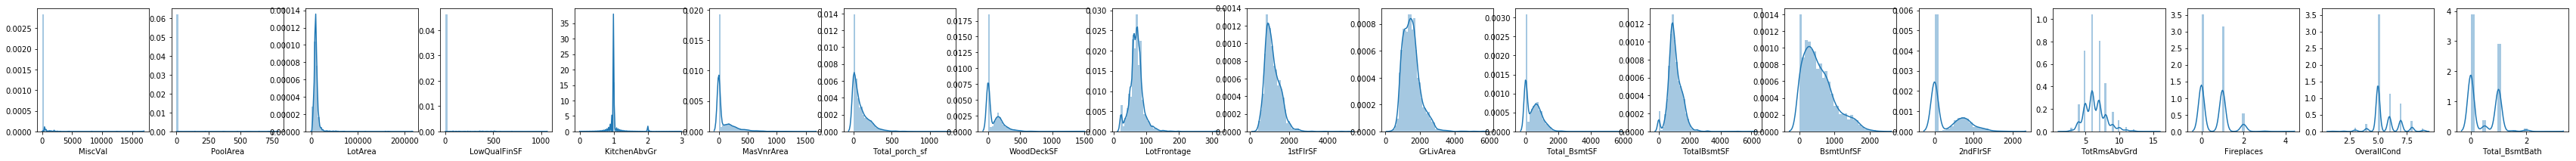

In [20]:
#Perform a frequency histogram for all numeric features with high skewness and observe the approximate distribution.
fig,axes=plt.subplots(1,len(cols),figsize=(60,3))
for i in range(len(cols)):
    sns.distplot(full[cols[i]],ax=axes[i])

In [21]:
for i in skew_index:
    full[i] = np.log1p(full[i])

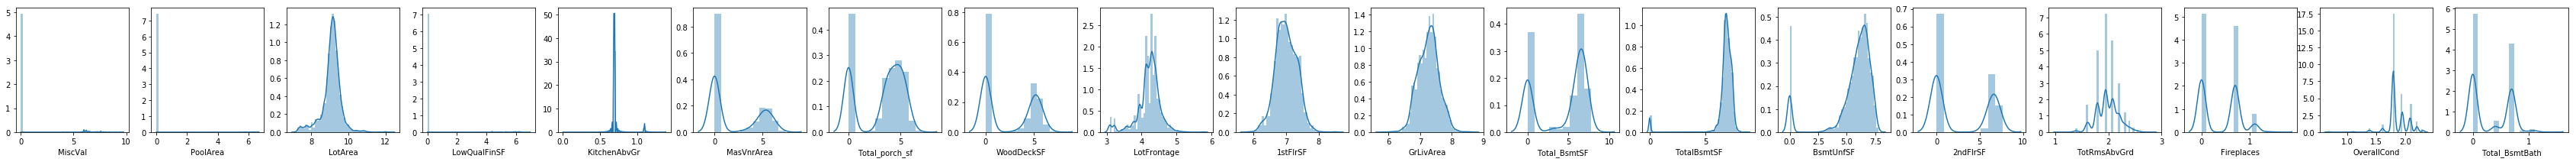

In [22]:
#Let's check it again
fig,axes=plt.subplots(1,len(cols),figsize=(60,3))
for i in range(len(cols)):
    sns.distplot(full[cols[i]],ax=axes[i])
#It's much better now

In [23]:
#Simplify the feature and process the value of 0 and 1.
full['PoolArea'] = full['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

In [24]:
#Apply one-hot processing to all discrete variables
final=pd.get_dummies(full)

In [25]:
#Separate the training set from the test set
final_train = final.iloc[:1460,:]
final_test = final.iloc[1460:,:]

In [26]:
#Set various parameters that we need needed(Quoted from https://www.kaggle.com/jesucristo/house-prices-solution-0-107-lb)
#Here we decide to compare the performance of three different regression model(rideg regression, lasso regression and elastic network)
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [27]:
#Make pipelines for cross validation(Quoted from https://www.kaggle.com/jesucristo/house-prices-solution-0-107-lb)
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))

In [28]:
#Define the output scores of cross validation (Quoted from https://www.kaggle.com/jesucristo/house-prices-solution-0-107-lb)
def cv_rmse(model, X=final_train):
    rmse = np.sqrt(-cross_val_score(model, X, SalePrice, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [29]:
#Get cross validation score for ridge regression model
score = cv_rmse(ridge)
print("rideg regression: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

rideg regression: 0.1239 (0.0234)



In [30]:
#Get cross validation score for lasso regression model
score = cv_rmse(lasso)
print("lasso regression: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lasso regression: 0.1214 (0.0240)



In [31]:
#Get cross validation score for elastic network model
score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

elastic net: 0.1214 (0.0240)



In [32]:
#Choose the best scoring model to learn the training machine
ridge_model_full_data = ridge.fit(final_train, SalePrice)
lasso_model_full_data = lasso.fit(final_train, SalePrice)
elastic_model_full_data = elasticnet.fit(final_train, SalePrice)

In [33]:
#Predict test set data using the learning results we got above
result1=np.expm1(ridge_model_full_data.predict(final_test))
result2=np.expm1(lasso_model_full_data.predict(final_test))
result3=np.expm1(elastic_model_full_data.predict(final_test))

In [34]:
#Output our prediction results for three models we applied above
submission1=pd.DataFrame({
    "Id":Id,
    "SalePrice":result1
})
submission1.to_csv('/Users/yeqingchen/Downloads/house-prices-advanced-regression-techniques/sample_submission1.csv',index=False)

submission2=pd.DataFrame({
    "Id":Id,
    "SalePrice":result2
})
submission2.to_csv('/Users/yeqingchen/Downloads/house-prices-advanced-regression-techniques/sample_submission2.csv',index=False)

submission3=pd.DataFrame({
    "Id":Id,
    "SalePrice":result3
})
submission3.to_csv('/Users/yeqingchen/Downloads/house-prices-advanced-regression-techniques/sample_submission3.csv',index=False)